In [46]:
from langgraph.graph import START , END , StateGraph , MessagesState
from langchain_ollama import ChatOllama
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.tools import tool 
from typing import Literal
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage


# Tool for Context Retrieval

In [ ]:
import os

# Check if the transcription file exists

file_path = "transcription.txt"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} not found.")

In [53]:
# Load LLM model
model = ChatOllama(model = "llama3.2:latest")

In [ ]:
def query_or_respond(state : MessagesState):
    """Generate tool call for retrieval or respond."""
    
    model_with_tools = model.bind_tools([retrieve])
    response = model_with_tools.invoke(state["messages"])

    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

In [74]:
def generate(state : MessagesState):

    """Generate a response to the user query."""

    # Get the last tool call message
    tool_messages = [
        message for message in state["messages"] if message.type == "tool"
    ]

    
    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    system_message_content = f"""
    You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer
    the question. If you don't know the answer, say that you
    don't know. Use three sentences maximum and keep the
    answer concise.
    {docs_content}
    """


    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = model.invoke(prompt)
    return {"messages" : [response]} # Returns as a list to add to the state

In [75]:
@tool
def retrieve(query: str):
    """Retrieve information related to a query from documents."""

    embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", 
                                             model_kwargs={'device': 'cpu'})

    loader = TextLoader(file_path)
    document = loader.load()

    splitter = RecursiveCharacterTextSplitter(chunk_size=500, 
                                              chunk_overlap=50, 
                                              length_function=len, 
                                              add_start_index=True)
    
    all_splits = splitter.split_documents(document)

    vectorstore = FAISS.from_documents(documents=all_splits, 
                                       embedding=embeddings_model)
    
    retriever = vectorstore.as_retriever()
    results = retriever.get_relevant_documents(query)  

    return "\n".join([doc.page_content for doc in results])

tools = [retrieve]
tool_node = ToolNode(tools)


In [76]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tool_node)
graph_builder.add_node(generate)

graph_builder.add_edge(START ,"query_or_respond" )
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

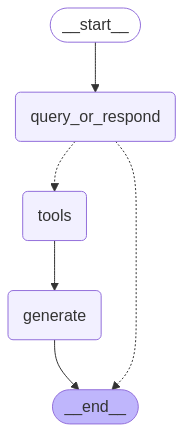

In [77]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [78]:
final_state = graph.invoke(
    {"messages": [HumanMessage(content="Co to jest AI thinkers na podstawie podcastu")]}
)

# Show the final response
print(final_state["messages"][-1].content)

AI Thinkers jest globalną organizacją założoną przez Zajawkowicza Seattle, która promuje rozwój technologii sztucznej inteligencji.
